# Panel dashboard with binned-merged data

## TODOs
- See https://github.com/amazon-riverbgc/TROCAS/blob/master/AppTODOs.md

## Recently completed tasks
- 9/22-21. 
    - Added initial elements of a range slider for parameter value, including a first pass at manually setting the min & max for the map via the slider (the map does react, but there are kinks: the slider values reset when switching from Licor CO2 to Picarro CO2; the map rendering reacts while I'm moving the slider, which makes for overly slow and jagged responses -- the update should be done manually via a button)
    - Moved colorbar to the top and toolbar to the right, so the colorbar (and its value range) is more closely aligned with the histogram x axis and the range slider
- 9/20-19
    - Implemented colorbar range (clim) checkbox to switch between the default, past behavior (range adjusts to the data) and the new default behavior (range is fixed to `parameter_attrs` minmax values).
    - Added date min & max to title over histogram, from inventory dataframe.
    - Added mean datetime to mbdata_dielcoll_pts_df and mbdata_dielcoll_points; see appdata.py
- 9/18
    - Added histogram y-tick-label formatter (`yformatter`) to use scientific notation
    - Helped stabilize the map (reduce re-adjustments) when zooming in and switching across parameters with contrasting value ranges, by using `frame_width` and `frame_height` and adding `colorbar_opts={'width':20}` to `geopoints` map
    - Holoviews-based mapping now works w/o requiring `import geoviews`
    - Experimented with a dynamic `clabel` on the map colormap
- 9/15-11.
    - Moved all the data ingest and processing code to a new module, `appdata`
    - Added choice of basemaps via a drop-down widget
    - Developed holoviews-based replacement for geoviews-based mapping, including the notebook-wide `HOLOVIEWSMAPPING` flag. But still couldn't get it to work w/o importing geoviews. It works with both but is slightly better with geoviews (axes degrees labels, etc).
    - Moved all extraneous, non-immediate comments to new, associated markdown notes file, `trocas_panelapp_1.md`
    - Changed github repo url to https://github.com/amazon-riverbgc
- 9/9. Tested successfully with new conda env, `holovizgen`, and with JupyterLab 2 (2.15)
- 4/20. Added customized web app HTML title. conda env used: `holoviztrocas_panelapp_latest2`
- 4/19-17. Changed basemap to tiles that don't fail regularly as Wikipedia was doing. Changed default app tab to be the map browser tab.
- 3/15. Huge progress on the histograms and drop-down labels! 
    - I got these things working: customized drop-down item labels, dynamic x-axis adjustment, x-axis range control, x-axis label hiding, dynamic title, and more
    - BUT actually, I had to revert the labeling of the drop-downs to column names, b/c I couldn't get the geopoints map plot to work otherwise

### Running this notebook as a stand-alone panel

Panel can be launched directly from here by running this statement:
```bash
! panel serve --show --port 5009 trocas_pannelapp_1.ipynb
```
But it's better to run it from the shell. Use the same command, except for the `!`.

The port number is chosen by the user, but it looks like it's conventional to choose one in the 5001-5009 range.

In [1]:
HOLOVIEWSMAPPING = False

In [2]:
from collections import OrderedDict as odict
from pathlib import Path
import requests
import numpy as np
import pandas as pd
import geopandas as gpd

import bokeh
import colorcet as cc, param as pm, holoviews as hv, panel as pn, datashader as ds
from holoviews.element import tiles
# from holoviews.operation.datashader import rasterize, shade, spread
import hvplot.pandas  # noqa

if HOLOVIEWSMAPPING:
    from holoviews import Points
    import datashader.geo
else:
    # Use this if using GeoViews to process and render the points
    from geoviews import Points
    import geoviews as gv

hv.extension('bokeh', logo=False)
pn.extension(logo=False)

In [3]:
from appdata import (
    get_mbdata, create_dielcollections, get_jeffstations, create_tr_sensorinventory)

See this warning from `import datashader.geo`, on 2020-9-9:
> /home/mayorga/miniconda/envs/holovizgen/lib/python3.8/site-packages/datashader/geo.py:24: VisibleDeprecationWarning: The datashader.geo module is deprecated as of version 0.11.0. Its contents have migrated to the xarray_spatial library, github.com/makepath/xarray-spatial.
  warnings.warn(

In [4]:
bokeh.__version__, cc.__version__, ds.__version__, hv.__version__, hvplot.__version__, pm.__version__, pn.__version__

('2.2.1', '1.0.0', '0.11.1', '1.13.3', '0.6.0', '1.9.3', '0.9.7')

In [5]:
if not HOLOVIEWSMAPPING: print(gv.__version__)

1.8.1


Versions from the last, prior successful run, 2020-4-20:
```python
bokeh.__version__, cc.__version__, ds.__version__, gv.__version__, hv.__version__, hvplot.__version__, pm.__version__, pn.__version__
('2.0.1', '1.0.0', '0.10.0', '1.8.1', '1.13.2', '0.5.2', '1.9.3', '0.9.5')
```

In [6]:
trocas_dpth = './data'
trocas_github_url = 'https://raw.githubusercontent.com/amazon-riverbgc/TROCAS/master/'

# Load and process data and inventory

## Binned-Merged data

In [7]:
mbdata_all_df, mbdata_df, mbdata_points = get_mbdata(Points, holoviewsmapping=HOLOVIEWSMAPPING)

len(mbdata_all_df), len(mbdata_df)

(114368, 58253)

**Note that only half of the binned-merged 1-min intervals have associated GPS data coordinates! This needs to be looked into.**

In [8]:
mbdata_all_df.columns

Index(['date_time', 'TROCAS_nbr', 'TROCAS_nbr_lico', 'TROCAS_nbr_gps',
       'longitude', 'latitude', 'collectiontype_lico', 'filename_lico',
       'reldirpath_lico', 'CO2(ppm)', 'TROCAS_nbr_sond', 'collectiontype_sond',
       'filename_sond', 'reldirpath_sond', 'ODO mg/L', 'pH', 'Temp °C',
       'Turbidity FNU', 'Chlorophyll µg/L', 'TROCAS_nbr_pica', '12CO2',
       'Delta_Raw_iCO2', '12CH4', 'Delta_iCH4_Raw'],
      dtype='object')

In [9]:
type(mbdata_points), print(mbdata_points)

:Dataset   [longitude,latitude]   (date_time,TROCAS_nbr,TROCAS_nbr_lico,TROCAS_nbr_gps,collectiontype_lico,filename_lico,reldirpath_lico,CO2(ppm),TROCAS_nbr_sond,collectiontype_sond,filename_sond,reldirpath_sond,ODO mg/L,pH,Temp °C,Turbidity FNU,Chlorophyll µg/L,TROCAS_nbr_pica,12CO2,Delta_Raw_iCO2,12CH4,Delta_iCH4_Raw,londeg,latdeg)


(geoviews.element.geo.Dataset, None)

## Diel stations: Extract diel file flags (collectiontype) and create points, by individual files via groupby

Save to Excel file for examination as needed.

In [10]:
mbdata_dielcoll_pts_df, mbdata_dielcoll_points = \
    create_dielcollections(Points, mbdata_df, save_to_excel=False)

len(mbdata_dielcoll_pts_df)

34

## Diel stations: "Jeff's" stations points

In [11]:
stations_gdf, stations_gv_vdims = get_jeffstations(Points, holoviewsmapping=HOLOVIEWSMAPPING)

print(stations_gv_vdims)

:Points   [Longitude,Latitude]   (name)


## Sensor inventory

In [12]:
trocasinventory_df, sensorinventory_df = create_tr_sensorinventory()

len(sensorinventory_df)

1185

# Widget selectors

## TROCAS, sensors, parameters

Dependent selectors below are based on [this post](https://stackoverflow.com/questions/57870870/how-do-i-automatically-update-a-dropdown-selection-widget-when-another-selection)

In [13]:
# TROCAS_nbr_lst = sorted(sensorinventory_df.TROCAS_nbr.unique().astype(int))
TROCAS_nbr_lst = sorted(mbdata_df.TROCAS_nbr.unique().astype(int))

In [14]:
parameter_attrs = {
    'CO2[ppm]': dict(units='ppm', minmax=(0, 10000)),
    'd13-CO2[o/oo]': dict(units='o/oo', minmax=(-30, -5)),
    'CH4[ppm??]': dict(units='ppm??', minmax=(0, 1000)),
    'd13-CH4[o/oo]': dict(units='o/oo', minmax=(-80, 10)),
    'Temperature[°C]': dict(units='°C', minmax=(24, 34)),
    'Diss. Oxygen[mg/L]': dict(units='mg/L', minmax=(0, 14)),
    'pH': dict(units='-', minmax=(4, 9)),
    'Turbidity[FNU]': dict(units='FNU', minmax=(0, 400)),
    'Chlorophyll[µg/L]': dict(units='µg/L', minmax=(-1.5, 6.5))
}
for p, d in parameter_attrs.items():
    d['step'] = (d['minmax'][1] - d['minmax'][0]) / 500

_obs_parameters = {
    'Licor': [
        ('CO2(ppm)', 'CO2[ppm]')
    ],
    'EXOSonde': [
        ('Temp °C', 'Temperature[°C]'), 
        ('ODO mg/L', 'Diss. Oxygen[mg/L]'), 
        ('pH', 'pH'), 
        ('Turbidity FNU', 'Turbidity[FNU]'), 
        ('Chlorophyll µg/L', 'Chlorophyll[µg/L]')
    ],
    'Picarro': [
        ('12CO2', 'CO2[ppm]'),
        ('Delta_Raw_iCO2', 'd13-CO2[o/oo]'),
        ('12CH4', 'CH4[ppm??]'),
        ('Delta_iCH4_Raw', 'd13-CH4[o/oo]')
    ]
}

parameter_tup_mapping = {ptup[0]:ptup[1] for sk,sv in _obs_parameters.items() for ptup in sv}

In [15]:
# Which obs parameter to use in the drop downs, from the tuples in _obs_parameters
# 0 is the first tuple element, the dataframe column name; 1 is the second element, the "label"
OP_IDX = 0

trocas_nbr = pn.widgets.Select(
    name='TROCAS Number',
    value='5', 
    options=[str(i) for i in TROCAS_nbr_lst],
    width=100
)

sensor = pn.widgets.Select(
    name='Sensor',
    value='Licor', 
    options=list(_obs_parameters.keys()),
    width=100
)

obs_parameter = pn.widgets.Select(
    name='Parameter',
    value=_obs_parameters[sensor.value][0][OP_IDX], 
    options=[param_tup[OP_IDX] for param_tup in _obs_parameters[sensor.value]],
    width=150
)

@pn.depends(sensor.param.value, watch=True)
def _update_obs_parameters(sensor):
    obs_parameter.value = _obs_parameters[sensor][0][OP_IDX]
    obs_parameter.options = [param_tup[OP_IDX] for param_tup in _obs_parameters[sensor]]

## Map color range (clim) schemes

In [16]:
clim_fixed = pn.widgets.Checkbox(name='Fixed colorbar range', value=True, width=150)

In [17]:
clim_range_slider = pn.widgets.RangeSlider(
    name='Select parameter range', 
    start=parameter_attrs[parameter_tup_mapping[obs_parameter.value]]['minmax'][0],
    end=parameter_attrs[parameter_tup_mapping[obs_parameter.value]]['minmax'][1],
    value=(
        parameter_attrs[parameter_tup_mapping[obs_parameter.value]]['minmax'][0],
        parameter_attrs[parameter_tup_mapping[obs_parameter.value]]['minmax'][1],
    ), 
    step=parameter_attrs[parameter_tup_mapping[obs_parameter.value]]['step'],
    width=720
)

@pn.depends(obs_parameter.param.value, watch=True)
def _update_param_rangeslider(obs_param_label):
    pattr = parameter_attrs[obs_param_label] if OP_IDX else parameter_attrs[parameter_tup_mapping[obs_param_label]]
    
    clim_range_slider.start = pattr['minmax'][0]
    clim_range_slider.end = pattr['minmax'][1]
    clim_range_slider.value = (pattr['minmax'][0], pattr['minmax'][1])
    clim_range_slider.step = pattr['step']

## Basemaps

In [18]:
basemap_names = ['ESRI WorldTopoMap', 'OSM', 'EsriImagery', 'CartoLight', 'StamenTonerBackground']

basemap_select = pn.widgets.Select(
    name='Basemap', 
    value='ESRI WorldTopoMap',
    options=basemap_names,
    width=150
)

# Plots and Maps

## Basemap

- I like Wikipedia best, but it's been failing regularly when the app is run as stand-alone, outside the notebook.
- This combination also works well: `tiles.EsriImagery() * tiles.StamenLabels()`

In [19]:
@pn.depends(basemap_name=basemap_select.param.value)
def set_basemap(basemap_name):
    if basemap_name == 'ESRI WorldTopoMap':
        basemap = hv.Tiles(
            ('http://services.arcgisonline.com/arcgis/rest/services/'
             'World_Topo_Map/MapServer/MapServer/tile/{Z}/{Y}/{X}'),
            name="ESRI WorldTopoMap", 
            label="ESRI WorldTopoMap"
        )
    else:
        basemap = tiles.tile_sources[basemap_name]()
    
    return basemap

basemap = hv.DynamicMap(set_basemap)

# Use this for testing:  pn.Row(set_basemap, basemap_select)

## Rasterize and spread all-TROCAS points as gray-scale background

*Code that used to work through mid Nov. 2019. See the notes document associated with this notebook*

## Map and Histogram plots

### Map

In [20]:
#size_opts = dict(width=800, height=600)
size_opts = dict(frame_width=730, frame_height=600)

geo_opts = dict(cmap=cc.fire, colorbar=True, colorbar_position='top', colorbar_opts={'height':16}) 
# , colorbar_opts={'width':20}  # logz=True,
if not HOLOVIEWSMAPPING:
    geo_opts['global_extent'] = False

In [21]:
def mbdata_points_tr(ds, sensor_val, obs_param_label, clim_fixed, clim_range, TROCAS_nbr=None):
    dssubset = ds if TROCAS_nbr is None else ds.select(TROCAS_nbr=TROCAS_nbr)
    
    if not OP_IDX:
        obs_param = obs_param_label
    else:
        # obs_param must be initialized
        obs_param = 'pH'
        for param_tup in _obs_parameters[sensor_val]:
            if param_tup[OP_IDX] == obs_param_label:
                obs_param = param_tup[not OP_IDX] 
                break

    if clim_fixed:
#         set_clim = (
#             parameter_attrs[obs_param_label]['minmax'] if OP_IDX 
#             else parameter_attrs[parameter_tup_mapping[obs_param_label]]['minmax']
#         )
        set_clim = (clim_range[0], clim_range[1])
    else:
        set_clim = (np.nan, np.nan)

    clabel = parameter_attrs[parameter_tup_mapping[obs_param]]['units']
    
    pointssubset = dssubset.to(Points, ['longitude', 'latitude'], [obs_param, 'date_time'], [])
    pointssubset.opts(
        color=obs_param, 
        clim=set_clim
    )
    # The statement below doesn't actually result in dynamic updates; it just sets the string once, initially.
    # Why doesn't it work, when an effectively identical scheme in param_hist() does work!?
    # pointssubset.opts(clabel=clabel)
    # This is an alternative that also didn't work, didn't even produce a clabel
    # pointssubset.opts(colorbar_opts={"title":f"{clabel}"})
    
    return pointssubset

geopoints = mbdata_points.apply(
    mbdata_points_tr, 
    sensor_val=sensor.param.value,
    obs_param_label=obs_parameter.param.value,
    clim_fixed=clim_fixed.param.value,
    clim_range=clim_range_slider.param.value,
    TROCAS_nbr=trocas_nbr.param.value
).opts(**geo_opts)

geopoints_alltr = mbdata_points.apply(
    mbdata_points_tr, 
    sensor_val=sensor.param.value,
    obs_param_label=obs_parameter.param.value,
    clim_fixed=clim_fixed.param.value,
    clim_range=clim_range_slider.param.value,
    TROCAS_nbr=None
).opts(**geo_opts)

In [22]:
mainmap = (
    basemap 
    # * spreaded_postds  # Commented out while trying to make it work with the latest holoviz packages
    #* (geopoints.apply(mbdata_points_tr_map, sensor.param.value, obs_parameter.param.value)    
    * (
        geopoints
        # .apply.opts(color=obs_parameter.param.value)
        .opts(size=3, clipping_colors={'NaN':'transparent'})
    )
    * stations_gv_vdims.opts(
        color='green', size=20, marker='diamond', show_legend=True, tools=['hover']
    )
    * mbdata_dielcoll_points.opts(
        color='blue', size=6, marker='square', show_legend=True, tools=['hover']
    )
).opts(**size_opts, toolbar='right', legend_position='top_left', xlabel='', ylabel='') # xaxis=None, yaxis=None)

### Histograms

In [23]:
def param_hist(ds, TROCAS_nbr, sensor_val, 
               obs_param_label, num_bins=40, bin_range="default"):
    if isinstance(bin_range, (tuple, list)) and len(bin_range) == 2:
        set_bin_range = bin_range
    elif bin_range == "default":
        set_bin_range = (
            parameter_attrs[obs_param_label]['minmax'] if OP_IDX 
            else parameter_attrs[parameter_tup_mapping[obs_param_label]]['minmax']
        )
    
    hist = ds.hist(adjoin=False, num_bins=num_bins, bin_range=set_bin_range)
    if TROCAS_nbr is None:
        return hist
    else:
        trocas_select = trocasinventory_df.query(f"TROCAS_nbr == '{TROCAS_nbr}'").iloc[0]
        tr_date_min = '{:%Y-%m-%d}'.format(trocas_select['date_time_min'])
        tr_date_max = '{:%Y-%m-%d}'.format(trocas_select['date_time_max'])
        obs_param_title = obs_param_label if OP_IDX else parameter_tup_mapping[obs_param_label]
        return hist.opts(title=f"TROCAS {TROCAS_nbr}, {tr_date_min} - {tr_date_max}: {sensor_val} {obs_param_title}")

In [24]:
hist = geopoints.apply(
    param_hist, 
    TROCAS_nbr=trocas_nbr.param.value,
    sensor_val=sensor.param.value,
    obs_param_label=obs_parameter.param.value,
    num_bins=60,
    # Passing a specific bin_range sequence works too! bin_range=(0,5000)
)

hist_alltr = geopoints_alltr.apply(
    param_hist, 
    TROCAS_nbr=None,
    sensor_val=sensor.param.value,
    obs_param_label=obs_parameter.param.value,
    num_bins=60,
).opts(color='gray')

## Construct the Data Browser Tab panel

In [25]:
browser_tab = (
    'Data Browser', 
    pn.Row(
        pn.Column(
            (hist_alltr.opts(framewise=True) * hist.opts(framewise=True, alpha=0.6)).opts(
                xlabel='', yformatter='%.1e', padding=(0.03, 0), width=800, height=200, toolbar=None
            ),
            pn.Row(pn.Spacer(width=50), clim_range_slider),
            mainmap
        ),
        pn.Column(
            pn.WidgetBox(
                '### Selectors',
                trocas_nbr, 
                pn.WidgetBox(sensor, obs_parameter, background='white')
            ),
            pn.WidgetBox(
                '### Map customization', 
                clim_fixed, 
                basemap_select
            )
        )
    )
)

## Documentation and supplementary App Tabs

Read text for `aboutdb_tab` and `about_trocas_tab` from markdown files on my TROCAS github repo.

In [26]:
def read_github_markdown_doc(filename):
    markdowndoc_req = requests.get(trocas_github_url + filename)
    return markdowndoc_req.text

databrowser_md = read_github_markdown_doc('AboutDataBrowser.md')
abouttrocas_md = read_github_markdown_doc('AboutTROCAS.md')
missingdatainv_md = read_github_markdown_doc('MissingDataInventory.md')

In [27]:
aboutdb_tab = (
    'About Data Browser',
    pn.Column(pn.pane.Markdown(databrowser_md), 
              pn.panel('./docs/TROCASapp_screenshot_annotated.png', width=650),
              width=700)
)

abouttrocas_tab = (
    'TROCAS Project',
    pn.Column(pn.pane.Markdown(abouttrocas_md), width=500)
)

In [28]:
def colwidth_hook(plot, element):
    for i in range(7):
        width = 110 if i in [1, 2] else 50
        plot.handles['table'].columns[i].width = width

trocasinv_hvtable = hv.Table(trocasinventory_df)

In [29]:
trocasinv_tab = (
    'Inventory',
    pn.Column(
        pn.pane.Markdown("""  
## TROCAS transect inventory
For each TROCAS transect ("TR"), this table shows date-time ranges for data collected, 
and availability of data for each underway sensor type. For some sensors in some transects, 
only a very small fragment of data are currently available and processed. 
This sample inventory table can not identify those cases.

""")
        , trocasinv_hvtable.opts(width=600, fit_columns=True, hooks=[colwidth_hook])
        , pn.pane.Markdown(missingdatainv_md, width=800)
        , width=900)
)

## Serve the Panel App

Tabs
    [0] Row
        [0] Column
            [0] HoloViews(DynamicMap)
            [1] Row
                [0] Spacer(width=50)
                [1] RangeSlider(end=10000, name='Select parameter range', step=20.0, value=(0, 10000), width=720)
            [2] HoloViews(DynamicMap)
        [1] Column
            [0] WidgetBox
                [0] Markdown(str)
                [1] Select(name='TROCAS Number', options=['1', '2', '3', ...], value='5', width=100)
                [2] WidgetBox(background='white')
                    [0] Select(name='Sensor', options=['Licor', 'EXOSonde', ...], value='Licor', width=100)
                    [1] Select(name='Parameter', options=['CO2(ppm)'], value='CO2(ppm)', width=150)
            [1] WidgetBox
                [0] Markdown(str)
                [1] Checkbox(name='Fixed colorbar range', value=True, width=150)
                [2] Select(name='Basemap', options=['ESRI WorldTopoMap', ...], value='ESRI WorldTopoMap', width=150)
    [1] Column(width=900)
        [0] Markdown(str)
        [1] HoloViews(Table)
        [2] Markdown(str, width=800)
    [2] Column(width=700)
        [0] Markdown(str)
        [1] PNG(str, width=650)
    [3] Column(width=500)
        [0] Markdown(str)
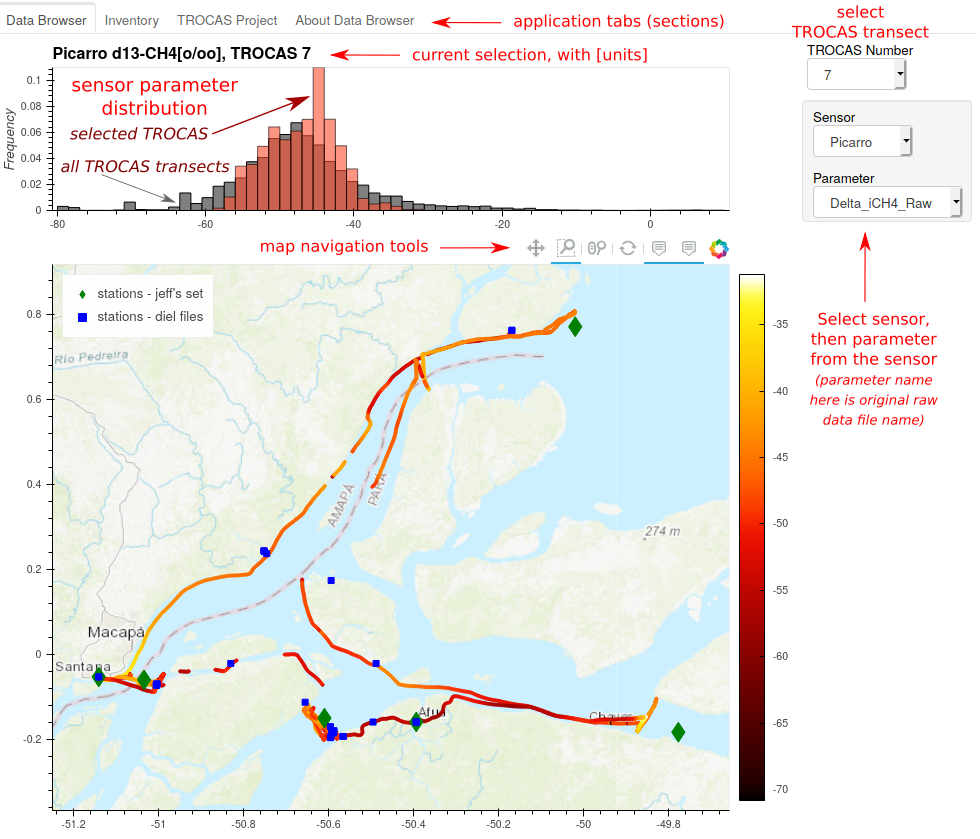

In [30]:
pn.Tabs(
    browser_tab, trocasinv_tab, aboutdb_tab, abouttrocas_tab
).servable(title='TROCAS Data Browser')

In [31]:
#!panel serve --show --port 5009 trocas_pannelapp_1.ipynb